In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random

In [2]:
def neighbor_edges_of_node(graph, node):
    neighbor_edges = []
    for edge in graph.edges():
        if node in edge:
            neighbor_edges.append(edge)
    return neighbor_edges

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/ga_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        if coloring_result == -1:
            result_file.write("Time limit exceeded.\n")
            print("Time limit exceeded.\n")
        else:
            if coloring_result:
                result_file.write("Minimum edge coloring found.\n")
                result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
                result_file.write(f"Number of iterations: {iter}\n")

                print("Minimum edge coloring found.")
                print("Number of colors:", len(set(coloring_result)))  
                print("Number of iterations:", iter)
                draw_colored_graph(graph, coloring_result)
                plt.close() 
            else:
                result_file.write("No solution found.\n")
                print("No solution found.\n") 

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [8]:
def is_feasible(solution):
    return any(solution)

In [9]:
class Individual:
    def __init__(self, graph):
        self.graph = graph  
        self.num_of_edges = len(graph.edges())
        self.coloring = [random.randrange(1, len(graph.edges())) for _ in range(len(graph.edges()))]
        self.fitness = self.calc_fitness()  

    
    def calc_fitness(self):
        graph = self.graph
        edge_color = {edge: self.coloring[i] for i, edge in enumerate(graph.edges())}
        num = 0
    
        for edge in graph.edges():
            indicator = True
    
            u, v = edge
            
            u_edges = neighbor_edges_of_node(graph, u)
            v_edges = neighbor_edges_of_node(graph, v)
    
            u_edges.remove(edge)
            v_edges.remove(edge)
            
            for i in range(len(u_edges)):
                if edge_color[u_edges[i]] == edge_color[edge]:
                    indicator = False
            
            for j in range(len(v_edges)):  
                if edge_color[v_edges[j]] == edge_color[edge]:
                    indicator = False
    
            if indicator:
                num += 1

        return num


In [10]:
def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    return max(chosen, key=lambda x: x.fitness)

In [11]:
def crossover(parent1, parent2, child1, child2):
    random_pos = random.randrange(0, len(parent1.coloring))
    
    child1.coloring[:random_pos] = parent1.coloring[:random_pos]
    child1.coloring[random_pos:] = parent2.coloring[random_pos:]
    
    child2.coloring[:random_pos] = parent2.coloring[:random_pos]
    child2.coloring[random_pos:] = parent1.coloring[random_pos:]

In [12]:
def mutation(individual, mutation_prob):
    for i in range(len(individual.coloring)):
        if random.random() < mutation_prob:
            new_color = random.randrange(1, individual.num_of_edges)
            while new_color == individual.coloring[i]:
                new_color = random.randrange(1, individual.num_of_edges)
            individual.coloring[i] = new_color

In [13]:
def genetic_algorithm(graph, population_size, num_generations, tournament_size, elitism_size, mutation_prob):

    population = [Individual(graph) for _ in range(population_size)]
    new_population = population.copy()

    for i in range(num_generations):
        population.sort(key=lambda x: x.fitness, reverse=True)
        new_population[:elitism_size] = population[:elitism_size]
        
        for j in range(elitism_size, population_size, 2):
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size) 
            
            crossover(parent1, parent2, child1=new_population[j], child2=new_population[j+1])

            mutation(new_population[j], mutation_prob)
            mutation(new_population[j+1], mutation_prob)
            
            new_population[j].fitness = new_population[j].calc_fitness()
            new_population[j+1].fitness = new_population[j+1].calc_fitness()
        
        population = new_population.copy()
        
        best_individual = max(population, key=lambda x: x.fitness)

        idx = population.index(best_individual)

    if is_valid_coloring(graph, best_individual.coloring):
        idx = population.index(best_individual)
        return best_individual, idx
    else:
        return -100, -100


In [14]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_individual, index = genetic_algorithm(graph, 
                                                population_size=100,
                                                num_generations=10,
                                                tournament_size=7,
                                                elitism_size=10,
                                                mutation_prob=0.05)
            end_time = time.time()

            if best_individual == -100:
                write_output(graph, file, None, index, start_time, end_time)
            else:
                write_output(graph, file, best_individual.coloring, index, start_time, end_time)     

Running test graph_101_edges.txt...


[20, 84, 77, 18, 32, 96, 10, 74, 33, 11, 85, 89, 16, 40, 54, 8, 78, 38, 12, 14, 48, 88, 96, 33, 92, 8, 59, 82, 25, 16, 66, 13, 80, 30, 71, 72, 52, 90, 19, 55, 10, 4, 51, 64, 37, 28, 60, 5, 91, 13, 30, 47, 49, 50, 67, 38, 3, 95, 59, 63, 32, 31, 28, 4, 75, 16, 29, 19, 94, 41, 17, 87, 6, 96, 34, 72, 73, 86, 35, 89, 3, 95, 46, 35, 71, 100, 91, 53, 39, 47, 30, 82, 58, 14, 54, 32, 34, 89, 10, 19, 42]
Minimum edge coloring found.
Number of colors: 69
Number of iterations: 4


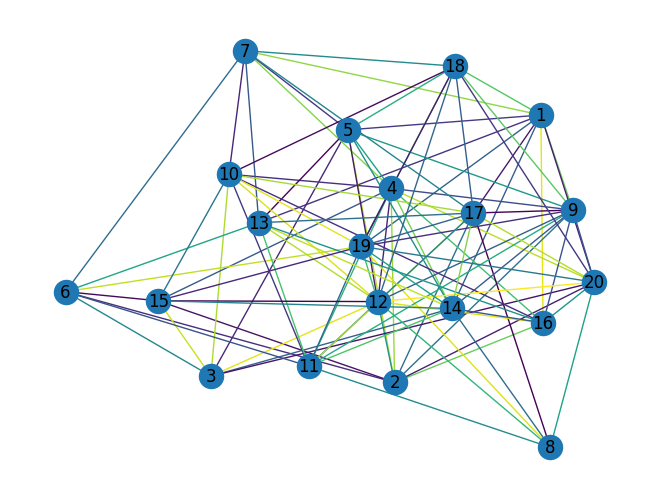

Time taken: 19.96733832359314 seconds

Running test graph_121_edges.txt...
[106, 94, 18, 66, 32, 120, 17, 21, 70, 8, 84, 88, 98, 54, 95, 88, 25, 12, 110, 71, 118, 6, 83, 97, 27, 59, 64, 6, 38, 92, 111, 21, 58, 79, 101, 51, 116, 44, 48, 34, 2, 85, 54, 100, 13, 39, 42, 71, 59, 23, 33, 76, 13, 62, 77, 85, 13, 69, 34, 96, 76, 93, 41, 86, 74, 69, 77, 74, 120, 3, 117, 79, 84, 107, 24, 1, 108, 57, 68, 81, 112, 34, 4, 43, 6, 114, 81, 110, 63, 61, 113, 66, 89, 29, 16, 91, 70, 2, 24, 26, 57, 109, 37, 110, 102, 44, 91, 54, 104, 56, 18, 10, 39, 92, 21, 56, 48, 82, 23, 69, 65]
Minimum edge coloring found.
Number of colors: 83
Number of iterations: 4


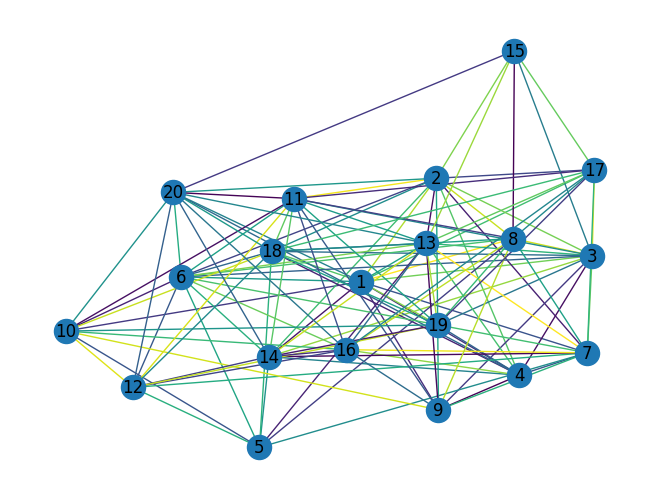

Time taken: 21.669008493423462 seconds

Running test graph_140_edges.txt...
[126, 132, 78, 44, 139, 124, 27, 74, 55, 45, 32, 96, 97, 39, 48, 128, 93, 121, 124, 101, 118, 66, 95, 82, 117, 58, 75, 34, 16, 74, 124, 4, 33, 76, 94, 55, 61, 118, 138, 47, 112, 60, 21, 12, 22, 109, 95, 82, 8, 87, 113, 110, 130, 81, 93, 117, 48, 45, 95, 134, 84, 97, 48, 58, 107, 16, 133, 11, 51, 138, 103, 114, 86, 36, 118, 2, 108, 1, 69, 74, 82, 112, 68, 131, 48, 73, 68, 100, 45, 102, 30, 14, 80, 50, 23, 139, 100, 122, 92, 34, 126, 136, 121, 35, 68, 7, 84, 86, 39, 50, 130, 113, 72, 124, 59, 47, 87, 5, 129, 67, 2, 119, 32, 46, 81, 50, 41, 76, 83, 57, 132, 49, 16, 82, 32, 51, 93, 7, 31, 75]
Minimum edge coloring found.
Number of colors: 88
Number of iterations: 0


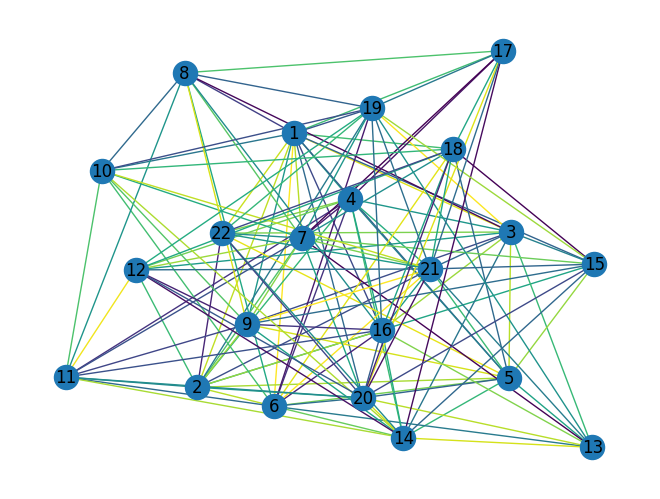

Time taken: 31.050508499145508 seconds

Running test graph_156_edges.txt...
[118, 65, 23, 80, 124, 143, 20, 86, 155, 151, 144, 137, 153, 92, 55, 60, 22, 66, 14, 67, 124, 140, 61, 144, 25, 84, 74, 126, 62, 91, 10, 155, 119, 75, 7, 137, 89, 82, 2, 79, 18, 103, 96, 78, 5, 63, 16, 112, 13, 22, 14, 39, 130, 128, 75, 8, 134, 48, 63, 121, 106, 146, 94, 90, 125, 89, 24, 43, 81, 137, 100, 51, 115, 110, 3, 97, 10, 117, 26, 13, 99, 55, 88, 106, 154, 127, 1, 36, 114, 132, 75, 123, 49, 23, 87, 151, 143, 153, 53, 135, 34, 23, 113, 138, 108, 119, 41, 1, 43, 103, 55, 44, 36, 145, 147, 31, 30, 120, 63, 17, 77, 44, 15, 108, 2, 52, 150, 12, 6, 88, 151, 17, 84, 30, 39, 140, 49, 147, 148, 59, 50, 109, 119, 29, 57, 116, 32, 7, 122, 98, 57, 154, 95, 54, 22, 151]
Minimum edge coloring found.
Number of colors: 111
Number of iterations: 18


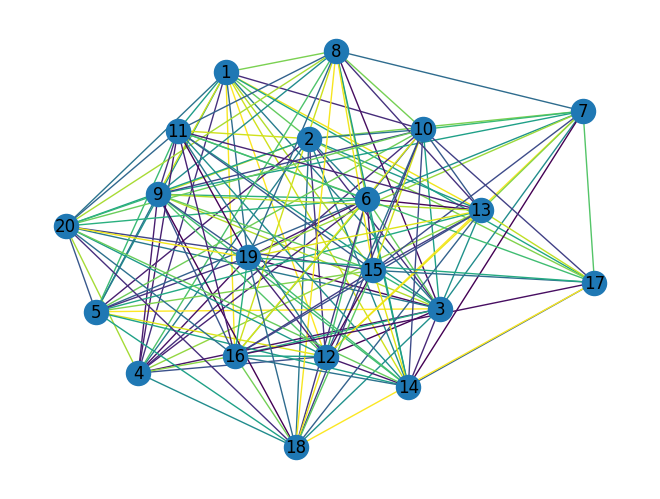

Time taken: 34.724984645843506 seconds

Running test graph_165_edges.txt...
[22, 121, 92, 43, 106, 110, 12, 141, 164, 162, 60, 35, 79, 122, 102, 19, 147, 39, 38, 69, 143, 156, 48, 103, 112, 111, 64, 138, 48, 107, 155, 90, 164, 116, 94, 51, 15, 62, 82, 136, 4, 105, 151, 45, 13, 58, 3, 161, 44, 18, 138, 16, 103, 46, 114, 86, 141, 103, 85, 110, 77, 11, 88, 25, 13, 133, 113, 158, 146, 27, 153, 149, 100, 151, 109, 124, 148, 85, 62, 157, 90, 87, 97, 10, 115, 49, 7, 88, 119, 16, 96, 97, 138, 52, 19, 139, 36, 69, 143, 75, 48, 62, 119, 71, 161, 15, 65, 118, 114, 47, 32, 63, 144, 113, 131, 94, 74, 21, 18, 1, 80, 162, 98, 52, 66, 24, 88, 134, 126, 45, 67, 27, 8, 53, 109, 64, 141, 95, 27, 21, 131, 1, 39, 133, 110, 14, 42, 139, 148, 111, 163, 81, 127, 24, 93, 94, 110, 91, 70, 64, 127, 86, 43, 96, 53]
Minimum edge coloring found.
Number of colors: 110
Number of iterations: 1


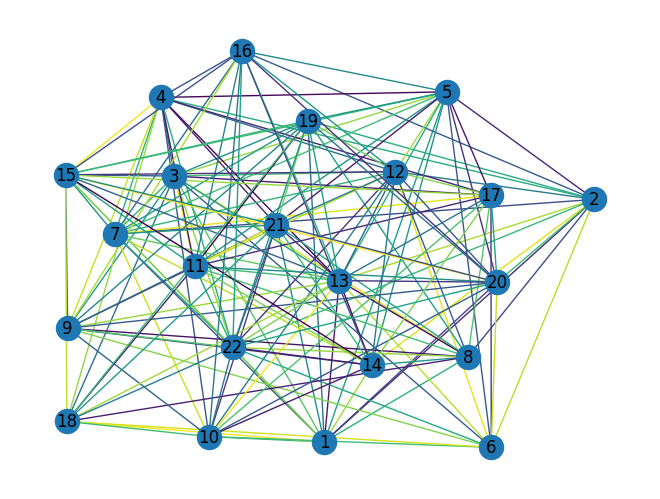

Time taken: 37.463077783584595 seconds

Running test graph_177_edges.txt...
[117, 10, 151, 172, 81, 34, 23, 133, 136, 22, 43, 100, 102, 41, 67, 122, 63, 137, 114, 161, 132, 7, 84, 30, 146, 107, 98, 41, 43, 167, 21, 152, 56, 122, 165, 7, 122, 86, 133, 43, 98, 4, 19, 71, 151, 34, 92, 64, 85, 69, 92, 149, 132, 45, 98, 49, 36, 2, 144, 50, 154, 151, 170, 105, 42, 22, 17, 32, 103, 13, 66, 16, 52, 154, 120, 37, 23, 105, 39, 144, 112, 62, 102, 173, 104, 19, 114, 106, 103, 159, 76, 111, 14, 47, 9, 119, 159, 176, 110, 89, 98, 46, 126, 4, 113, 79, 170, 131, 165, 104, 81, 146, 25, 126, 67, 76, 135, 99, 175, 133, 91, 20, 14, 19, 49, 129, 138, 89, 48, 105, 157, 79, 158, 134, 99, 28, 169, 156, 158, 64, 62, 164, 141, 131, 59, 11, 129, 60, 82, 37, 30, 13, 93, 74, 80, 159, 96, 163, 69, 27, 91, 139, 41, 60, 31, 47, 167, 172, 35, 169, 121, 175, 109, 41, 26, 128, 88]
Minimum edge coloring found.
Number of colors: 116
Number of iterations: 6


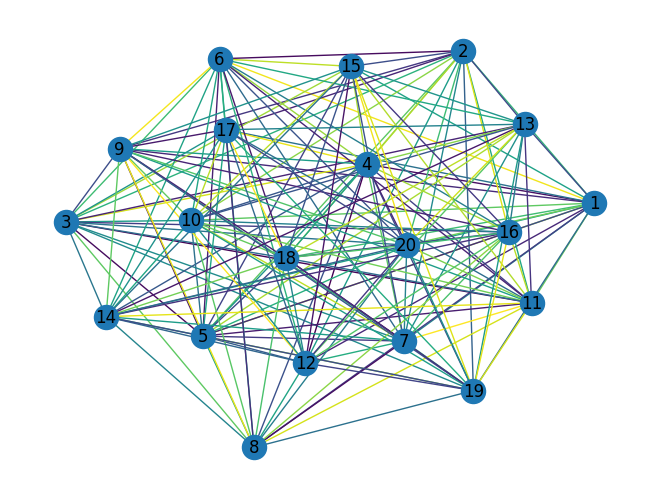

Time taken: 40.507105350494385 seconds

Running test graph_204_edges.txt...
None
No solution found.

Time taken: 54.94148254394531 seconds

Running test graph_227_edges.txt...
[138, 186, 121, 149, 39, 146, 172, 111, 116, 80, 68, 91, 177, 174, 162, 217, 71, 28, 197, 35, 55, 2, 56, 7, 18, 40, 68, 91, 207, 213, 89, 134, 56, 42, 157, 29, 130, 202, 76, 15, 52, 65, 37, 191, 55, 121, 59, 133, 209, 67, 23, 83, 98, 163, 66, 170, 25, 31, 44, 141, 204, 19, 91, 213, 80, 74, 25, 62, 164, 51, 126, 111, 149, 4, 97, 63, 116, 172, 10, 132, 67, 180, 100, 209, 117, 173, 102, 36, 162, 109, 119, 100, 141, 72, 26, 28, 13, 215, 108, 23, 3, 121, 8, 60, 4, 203, 102, 24, 177, 76, 209, 143, 208, 90, 201, 54, 124, 172, 110, 221, 215, 127, 184, 204, 187, 139, 225, 160, 132, 105, 151, 9, 158, 31, 7, 57, 128, 34, 176, 175, 155, 32, 216, 22, 196, 90, 176, 107, 109, 23, 13, 146, 53, 67, 101, 127, 179, 14, 161, 126, 166, 160, 219, 146, 215, 164, 125, 40, 151, 57, 154, 99, 219, 39, 18, 217, 95, 64, 195, 89, 168, 155, 96

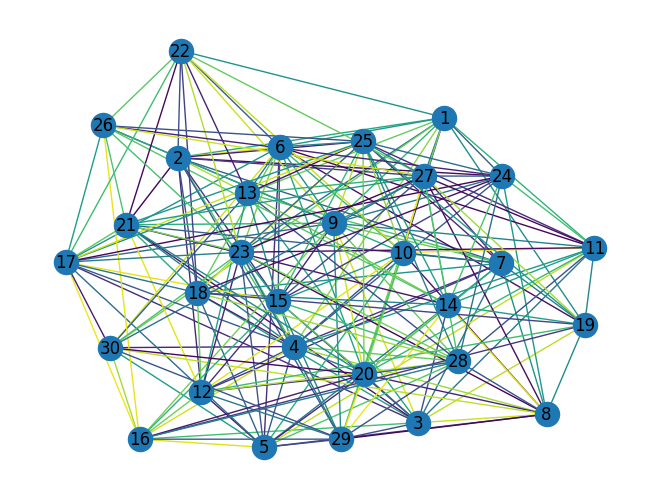

Time taken: 66.17659878730774 seconds

Running test graph_273_edges.txt...
None
No solution found.

Time taken: 88.73986458778381 seconds

Running test graph_275_edges.txt...
[29, 31, 177, 257, 144, 50, 113, 35, 202, 10, 210, 255, 87, 26, 122, 260, 156, 235, 1, 44, 114, 35, 23, 64, 126, 260, 25, 125, 24, 118, 214, 80, 53, 161, 190, 16, 145, 47, 208, 114, 131, 173, 186, 159, 240, 5, 121, 70, 101, 98, 21, 224, 195, 183, 164, 207, 22, 45, 271, 132, 14, 187, 76, 162, 185, 72, 192, 251, 32, 110, 256, 267, 205, 114, 234, 106, 120, 273, 84, 187, 21, 95, 8, 19, 4, 76, 201, 259, 27, 77, 158, 212, 222, 194, 198, 243, 71, 17, 109, 245, 26, 46, 154, 42, 133, 111, 14, 164, 86, 182, 83, 180, 134, 265, 96, 262, 123, 128, 223, 229, 235, 149, 21, 61, 274, 38, 137, 221, 210, 217, 242, 126, 125, 240, 268, 141, 106, 206, 155, 85, 157, 54, 137, 139, 86, 45, 3, 239, 245, 67, 11, 71, 17, 6, 54, 106, 229, 92, 150, 112, 77, 12, 81, 49, 241, 191, 21, 204, 73, 90, 62, 110, 14, 28, 196, 248, 231, 235, 78, 16, 250

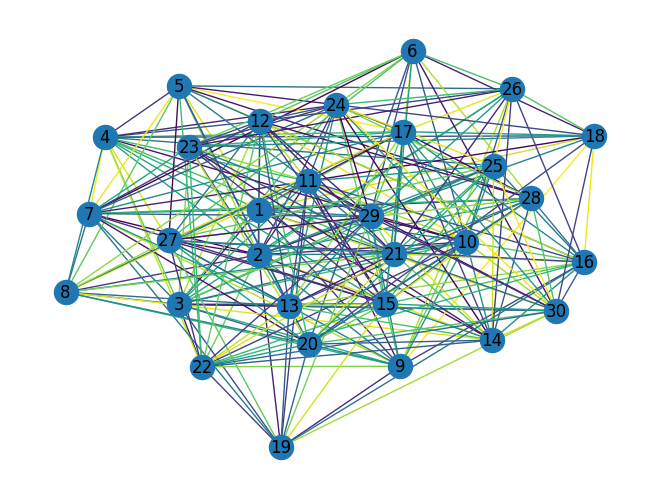

Time taken: 104.79869651794434 seconds



In [15]:
with open('./results/ga_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')